# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from loading and inspecting the dataset; -to implementing, training and evaluating a Convolutional Neural Network based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the list of objects provided, please pick at least 3 objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is April 21st Sunday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name: Li Kailang**  

**Neptun ID: FDQAOR**

**Network: Convolutional Neural Network**

**Objects: DND**

## Task description

Your task is to train your own custom object detection model and compare its performance with an existing object detection model (i.e. YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the metrics, losses, and predictions. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your network.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# ADD YOUR CODE HERE
import torch
import torchvision #has various utils functions, including loading datasets
import torchvision.transforms as transforms #common image transformations
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import time

import torch.nn as nn #creating neural network https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F #functional api for layers,...
import torch.optim as optim #for optimization algorithm
import matplotlib.pyplot as plt #for visualization
import matplotlib.image as mpimg
import numpy as np #for basic array operations
import os
import cv2
import random

#Set up GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 1. DATASET
For this assignment you will be using at least 3 of the [Mihály Kolodko's Mini Statues](https://www.atlasobscura.com/places/hidden-mini-statues-of-budapest).

You can find all of the objects seperately in a folder here: [Objects](https://drive.google.com/drive/folders/1QEEHye66USSWesGSVBQw1v1tk3Hr01G9?usp=sharing)

<img src='https://www.goethe.de/resources/files/jpg1201/161kolodkovojenyjkorabel-formatkey-jpg-w1920.jpg' />

### 1.1. Load objects

**Please select 3 or more objects.** Upon selecting the objects, **please remove the background, so that only the object is kept**. You can do it manually, online or by code (this is not part of the evaluation of your assignment).
As an example, the following objects have been chosen (the background was removed with Segment Anything Model):


*** before runing this code, please upload 3 images！！！ ***

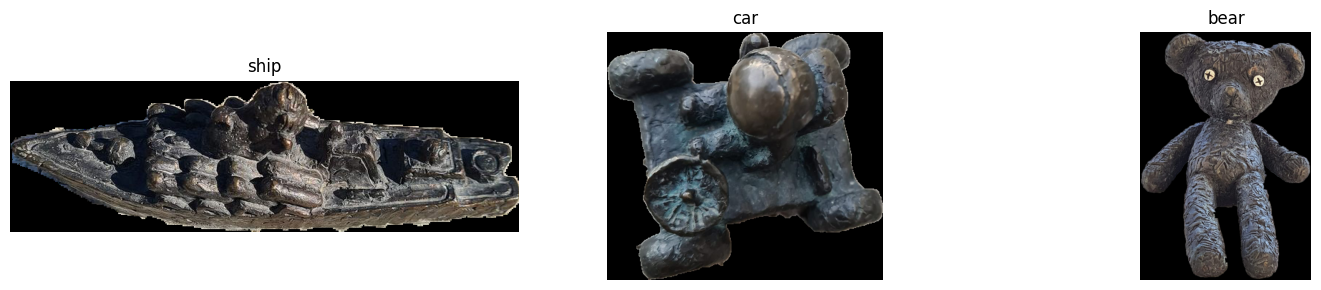

In [2]:
# ADD YOUR CODE HERE
#---------------------------------------------------------------------------------------
# 上传ps好的图片
# 检查并创建objects文件夹
dataset_dir = 'objects'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# 检查并移动上传的图片到dataset文件夹
uploaded_files = os.listdir('.')
for file_name in uploaded_files:
    if file_name.endswith('.png'):
        os.rename(file_name, os.path.join(dataset_dir, file_name))

#----------------------------------------------------------------------------------------------------
# 写一个display_objects_images(' ')函数，传入文件夹位置，对里面的图片进行可视化，上面是名字下面是图片。
def display_objects_images(image_folder_path):
  # 定义转换（Transforms），用于将图片转换成模型所需的张量
  transform = transforms.Compose([
       transforms.ToTensor()           # 转换为张量
  ])

    # 获取文件夹中的所有图片文件名
  image_filenames = os.listdir(image_folder_path)
    # 创建一个列表来存储每个图片的路径和标签
  dataset = []

  # 将每个图片的路径和标签添加到列表中
  for filename in image_filenames:
    label = os.path.splitext(filename)[0]  # 去掉文件后缀，假设文件名格式为 "label_image.png"
    image_path = os.path.join(image_folder_path, filename)
    dataset.append((image_path, label))

  # 定义一个函数来加载图片并应用转换
  def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # 以RGB模式打开图片
    image = transform(image)                      # 应用转换
    return image

  # 获取图片数量
  num_images = len(dataset)

  # 创建一个子图网格来显示图片和标签
  fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

  # 循环遍历数据集，加载图片并展示
  for i, (image_path, label) in enumerate(dataset):
    image_tensor = load_image(image_path)

    # 转换为NumPy数组，并交换轴以适应matplotlib
    image_np = image_tensor.numpy().transpose((1, 2, 0))

    # 显示图片及其标签
    axes[i].imshow(image_np)
    axes[i].set_title(label)
    axes[i].axis('off')

  # 调整布局
  plt.tight_layout()

  # 显示图片
  plt.show()

#---------------------------------------------------------------------------------------

display_objects_images('/content/objects')

In [3]:
# 加载图像
bear_img = cv2.imread('/content/objects/bear.png')
car_img = cv2.imread('/content/objects/car.png')
ship_img = cv2.imread('/content/objects/ship.png')


# 调整图像大小
desired_size = (112, 112)
bear_resized = cv2.resize(bear_img, desired_size)
car_resized = cv2.resize(car_img, desired_size)
ship_resized = cv2.resize(ship_img, desired_size)

# 将图像转换为张量
bear_tensor = torch.tensor(bear_resized)
car_tensor = torch.tensor(car_resized)
ship_tensor = torch.tensor(ship_resized)

# 打印张量的形状
print("Bear tensor shape:", bear_tensor.shape)
print("Car tensor shape:", car_tensor.shape)
print("Ship tensor shape:", ship_tensor.shape)

Bear tensor shape: torch.Size([112, 112, 3])
Car tensor shape: torch.Size([112, 112, 3])
Ship tensor shape: torch.Size([112, 112, 3])


### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:
- Inserting an object in a random position of a background image

We want to follow a similar pattern to what Mihály Kolodko did, by inserting the objects in the streets of Budapest. **Thus, collect a few background images of different locations in Budapest.** This can be done manually or via code. The recommendation is to use icrawler to collect them.

In [4]:
!pip install icrawler

In [5]:
!mkdir background

In [6]:
from icrawler.builtin import BingImageCrawler

bing_crawler = BingImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['budapest', 'budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
    bing_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto' , min_size=(500, 500),)

#Some images may return an error, but icrawler tries to find other images regardless

ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Parliament_Building%2C_Budapest%2C_outside.jpg
ERROR:downloader:Response status code 403, file https://get.pxhere.com/photo/architecture-night-building-chateau-palace-city-cityscape-panorama-dusk-evening-reflection-landmark-cathedral-danube-parliament-buda-budapest-hungary-pest-the-hungarian-parliament-night-parliament-night-budapest-610148.jpg
ERROR:downloader:Response status code 403, file https://get.pxhere.com/photo/horizon-architecture-skyline-night-palace-city-cityscape-panorama-dusk-evening-reflection-flood-landmark-capital-parliament-budapest-hungary-jjszaka-1012453.jpg
ERROR:downloader:Exception caught when downloading file https://jsis.washington.edu/euwesteurope/wp-content/uploads/sites/11/2018/07/St-Stephens-Basilica-Budapest-IMG_7220.jpg, error: HTTPSConnectionPool(host='jsis.washington.edu', port=443): Max retries exceeded with url: /euwesteurope/wp-content/uploads/si

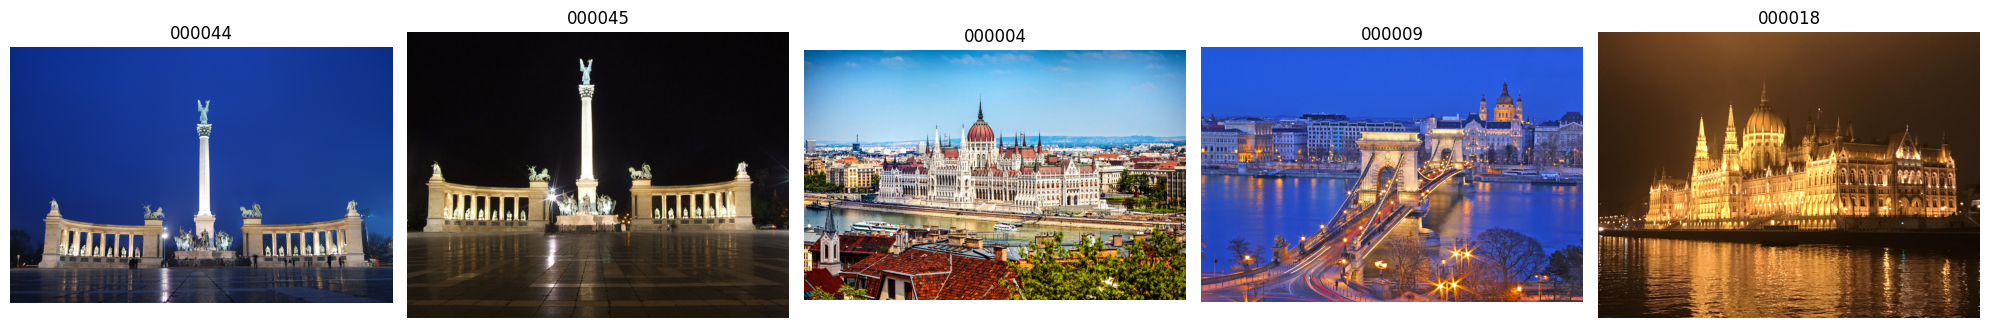

In [7]:
# 写一个display_sample_images函数

def display_sample_images(folder_path):
    # 获取文件夹中的图片文件列表
    image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    # 随机选择5张图片
    random_image_files = random.sample(image_files, min(len(image_files), 5))

    # 创建画布
    num_images = len(random_image_files)
    num_rows = 1 if num_images == 0 else (num_images + 4) // 5  # 每行显示5张图片
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows*4))

    # 遍历并显示图片
    for i, image_file in enumerate(random_image_files):
        row = 1
        col = i % 5

        # 读取图片并显示
        img = mpimg.imread(os.path.join(folder_path, image_file))
        if num_rows == 1:
            axes[col].imshow(img)
            axes[col].set_title(image_file[:-4], fontsize=12)  # 去掉文件名后缀
            axes[col].axis('off')
        else:
            axes[i // 5, col].imshow(img)
            axes[i // 5, col].set_title(image_file[:-4], fontsize=12)  # 去掉文件名后缀
            axes[i // 5, col].axis('off')

    plt.tight_layout()
    plt.show()

#-----------------------------------------------------------------------------------------
directory = '/content/background'
#Show some of the images, to confirm that they were successfully crawled
display_sample_images(directory)

### 1.3. Create dataset

Now it is time to create a dataset. This is the first important part of evaluation of the assignment.
From the selected objects and collected background images, do the following:
- Randomly select background images
- For each background image insert only 1 of the 3 select objects
- The object should be inserted at a random location
- Save the coordinates where the object was placed and create a bounding box from them. i.e. if the object with height h and width w was placed at position x,y, then the bounding box should be in the format [x,y,w,h] or [x1,y1,x2,y2] where x2=x1+w and y2=y1+h
- If you plan to compare your own custom model with a YOLO model, then use the YOLO format [((x+w/2)/image width), (x+y/2)/image height, w/image width, h/image height], where image is the background
- You may want to save the generated dataset, as it will be used later to train the custom model as well as fine-tune an existing one
- Wrap everything under a PyTorch Dataset class
- Create train, val and test sets

In [8]:
# ADD YOUR CODE HERE
#----------------------------------------------------------------------------------
# 写一个createDataset函数

#This my own function... It creates and saves a dataset in the following format:
# root/
#     dataset/
#             train/
#                   images/
#                         00001.jpg
#                   labels/
#                         00001.txt with the content [class yolo_x, yolo_y, yolo_w, yolo_h] following the yolo format
#             val
#...

def createDataset(root_dir, background_dir, split='train', img_size=(640,640), num_images=5000):
    # 创建数据集子目录
    dataset_dir = os.path.join(root_dir, 'dataset')
    split_dir = os.path.join(dataset_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    image_dir = os.path.join(split_dir, 'images')
    label_dir = os.path.join(split_dir, 'labels')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    # 从背景目录中随机选择图像
    background_images = os.listdir(background_dir)

    for i in range(num_images):
        # 从背景目录中随机选择一张图像
        background_image_name = random.choice(background_images)
        background_image_path = os.path.join(background_dir, background_image_name)

        # 加载背景图像
        background_image = cv2.imread(background_image_path)
        background_image = cv2.resize(background_image, img_size)

        #------------------------------------------------------------------------------
        # 在这里添加您的代码来处理图像，将对象放置在背景图像上，并生成相应的标签文件
        def insert_object_into_background(background_img, object_tensor):

            # 获取背景图像尺寸
            bg_height, bg_width, _ = background_img.shape

            # 获取对象张量尺寸
            obj_height, obj_width, _ = object_tensor.shape

            # 随机选择对象插入的位置
            x = random.randint(0, bg_width - obj_width)
            y = random.randint(0, bg_height - obj_height)

            # 在背景图像上插入对象
            background_image[y:y+obj_height, x:x+obj_width] = object_tensor

            # 计算并返回对象在YOLO格式下的bounding box坐标
            # 在这里假设对象在图像中的位置是(x, y)，宽度是obj_width，高度是obj_height
            # YOLO格式中的bounding box格式为 [choice, x_center, y_center, width, height]
            # ob_num = 0
            if torch.equal(object_tensor, ship_tensor):
                ob_num = 0
            elif torch.equal(object_tensor, car_tensor):
                ob_num = 1
            elif torch.equal(object_tensor, bear_tensor):
                ob_num = 2


            x_center = (x + x + obj_width) / 2 / bg_width
            y_center = (y + y + obj_height) / 2 / bg_height
            width = obj_width / bg_width
            height = obj_height / bg_height

            return background_image, [ob_num, x_center, y_center, width, height]

        # 随机选择一个对象
        selected_object = random.choice([bear_tensor, ship_tensor, car_tensor])

        # 插入对象到背景图像并获取bounding box坐标
        result_image, bbox = insert_object_into_background(background_image, selected_object)

        #---------------------------------------------------------------------------------

        # 保存图像和标签文件
        image_filename = f'{i+1:05d}.jpg'
        label_filename = f'{i+1:05d}.txt'
        cv2.imwrite(os.path.join(image_dir, image_filename), result_image)
        # 保存标签文件
        label_path = os.path.join(label_dir, label_filename)
        with open(label_path, 'w') as f:
          f.write(' '.join(map(str, bbox)))

        # 进度输出
        if (i+1) % 1000 == 0:
            print(f'Processed {i+1}/{num_images} images...')

    print('Dataset creation completed.')

#---------------------------------------------------------------------------------------------------------
createDataset('dataset', 'background', split='train', img_size=(640,640), num_images=5000) # my GPU can not affort too much images
createDataset('dataset', 'background', split='val', img_size=(640,640), num_images=1000) # the raw num_images should be *100
createDataset('dataset', 'background', split='test', img_size=(640,640), num_images=200)

Processed 1000/5000 images...
Processed 2000/5000 images...
Processed 3000/5000 images...
Processed 4000/5000 images...
Processed 5000/5000 images...
Dataset creation completed.
Processed 1000/1000 images...
Dataset creation completed.
Dataset creation completed.


In [9]:
# ADD YOUR CODE HERE
#------------------------------------------------------------------------------------
# 补全下面的类
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
       return len(self.image_filenames)
       # pass

    def __getitem__(self, idx):
       # 读取图像
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        # 读取标签
        label_name = image_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.label_dir, label_name)
        with open(label_path, 'r') as f:
            label_content = f.read().split()
        category = int(label_content[0])  # 类别
        bbox = [float(coord) for coord in label_content[1:]]  # Bounding box 坐标

       # pass

        if self.transform:
          image = self.transform(image)
           # pass

        return image, torch.tensor(category), torch.tensor(bbox) #generous hint

In [10]:
root_dir = 'dataset/dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

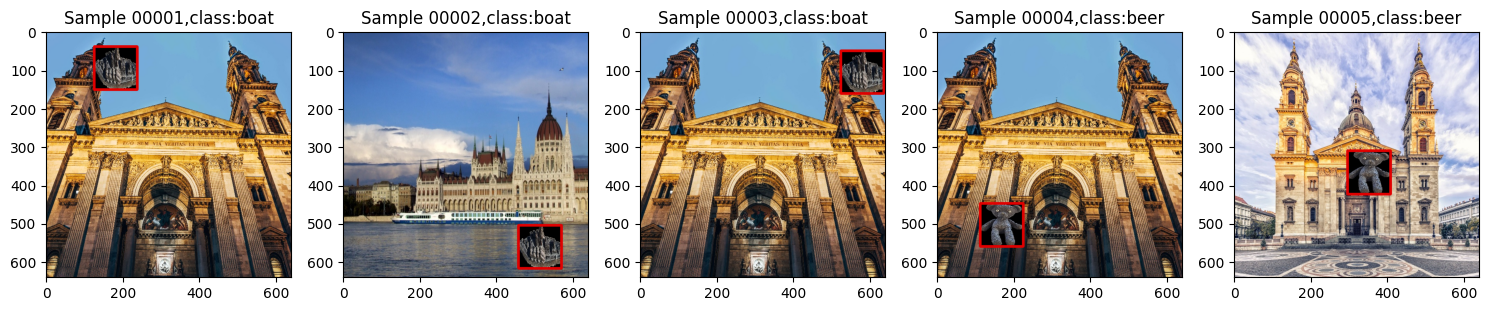

In [11]:
# ADD YOUR CODE HERE
# 写一个visualize_dataset函数,用来锚框
root_dir = 'dataset/dataset'
def visualize_dataset(root_dir, split='train', num_samples=5):
    images_dir = os.path.join(root_dir, split, 'images')
    labels_dir = os.path.join(root_dir, split, 'labels')

    # 获取数据集中的图像和标签文件列表
    image_files = sorted(os.listdir(images_dir))[:num_samples]
    label_files = sorted(os.listdir(labels_dir))[:num_samples]

    # 创建一个图像和标签文件路径的迭代器
    data_iterator = zip(image_files, label_files)

    # 创建一个包含num_samples个子图的图像
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, (image_file, label_file) in enumerate(data_iterator):
        # 读取图像和标签文件
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, label_file)
        image = cv2.imread(image_path)
        with open(label_path, 'r') as f:
            bbox_data = f.read().strip().split()

        # 检查bbox_data的长度是否是5的倍数
        if len(bbox_data) % 5 != 0:
            axes[i].text(0.5, 0.5, "Invalid bbox data", horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
            continue

        # 绘制锚框
        for j in range(0, len(bbox_data), 5):
            ob_num = int(bbox_data[j])
            x_center = float(bbox_data[j+1])
            y_center = float(bbox_data[j+2])
            width = float(bbox_data[j+3])
            height = float(bbox_data[j+4])
            x1 = int((x_center - width/2) * image.shape[1])
            y1 = int((y_center - height/2) * image.shape[0])
            x2 = int((x_center + width/2) * image.shape[1])
            y2 = int((y_center + height/2) * image.shape[0])
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 225), 5)

        # 将图像绘制在子图上
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # 设计标题
        if ob_num == 0 :
          axes[i].set_title(f"Sample 0000{i+1},class:boat")
        elif ob_num == 1 :
          axes[i].set_title(f"Sample 0000{i+1},class:car")
        elif ob_num == 2 :
          axes[i].set_title(f"Sample 0000{i+1},class:beer")

    plt.tight_layout()
    plt.show()

# 调用函数来展示前5个样本
visualize_dataset(root_dir, split='train', num_samples=5)

#-------------------------------------------------------------------------------------
# Show some visualizations of the created dataset
#visualize_dataset(train_dataset)

# 2. MODELS
For this assignment, you are required to create your own custom object detection model and compare its performance with an existing object detection model.

### 2.1. Custom Object Detection model

Create a Convolutional Neural Network based architecture that contains a backbone for feature extraction and two ouput branches:
- one for class probabilities (same size as the number of objects chosen, i.e. 3)
- another for bounding box regression (of size 4, due to the box coordinates x,y,w,h) or the chosen format

This is the main evaluation part of the assignment. Try combining different layers, try different hyper-parameters and include regularization.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=5, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        self.flatten = nn.Flatten()
        self.fc_cls = nn.Linear(64 * 32 * 32, num_classes)
        self.fc_bbox = nn.Linear(64 * 32 * 32, 4)

        # Loss and Optimizer
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.scheduler = ExponentialLR(self.optimizer, gamma=0.96)

    def forward(self, x):
        features = self.backbone(x)
        flattened_features = self.flatten(features)
        class_probs = self.fc_cls(flattened_features)
        bbox_regression = self.fc_bbox(flattened_features)
        return class_probs, bbox_regression

    def train_model(self, train_loader, val_loader, num_epochs, patience):
        early_stopping = EarlyStopping(patience=patience, verbose=True)

        for epoch in range(num_epochs):
            self.train()
            for data, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self(data)
                loss = self.loss_fn(outputs, targets)
                loss.backward()
                self.optimizer.step()
            self.scheduler.step()

            # Validation phase
            val_loss = 0
            self.eval()
            with torch.no_grad():
                for data, targets in val_loader:
                    outputs = self(data)
                    loss = self.loss_fn(outputs, targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f'Epoch {epoch+1}, Val Loss: {val_loss}')
            early_stopping(val_loss, self)
            if early_stopping.early_stop:
                print("Early stopping")
                break

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [14]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train your model
Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Make sure to optimize both classification and bounding box regression losses.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10, Train Loss: 1.1356289641925703, Val Loss: 1.1298649746274192
Epoch 2/10, Train Loss: 1.12967115354995, Val Loss: 1.1288353885923113
Epoch 3/10, Train Loss: 1.1303761675715827, Val Loss: 1.1267051904920549
Epoch 4/10, Train Loss: 1.0642405184693993, Val Loss: 0.6906027306639959
Epoch 5/10, Train Loss: 0.2763418367805001, Val Loss: 0.07704948527472359
Epoch 6/10, Train Loss: 0.0547036915636672, Val Loss: 0.0215386687408364
Epoch 7/10, Train Loss: 0.027600425810288317, Val Loss: 0.011738535874183215
Epoch 8/10, Train Loss: 0.018621821242113843, Val Loss: 0.0084560323610074
Epoch 9/10, Train Loss: 0.013408937256414288, Val Loss: 0.0063390204801209386
Epoch 10/10, Train Loss: 0.010143162047389312, Val Loss: 0.004220038922207933


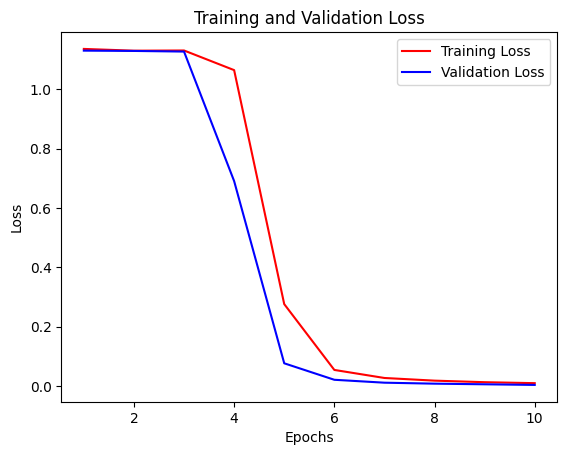

In [15]:
# ADD YOUR CODE HERE
def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for batch in train_loader:
            images, category, bbox = batch[0], batch[1], batch[2]  # 假设train_loader返回的是一个列表，其中包含图像、类别和边界框

            images, category, bbox = images.to(device), category.to(device), bbox.to(device)

            optimizer.zero_grad()

            class_probs, bbox_regression = model(images)

            class_loss = class_loss_fn(class_probs, category)
            bbox_loss = bbox_loss_fn(bbox_regression, bbox)

            loss = class_loss + bbox_loss
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            epoch_val_loss = 0.0
            for batch in val_loader:
                images, category, bbox = batch  # 假设val_loader也返回的是一个列表

                images, category, bbox = images.to(device), category.to(device), bbox.to(device)

                class_probs, bbox_regression = model(images)

                class_loss = class_loss_fn(class_probs, category)
                bbox_loss = bbox_loss_fn(bbox_regression, bbox)

                loss = class_loss + bbox_loss
                epoch_val_loss += loss.item()

            val_losses.append(epoch_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

    return train_losses, val_losses
#---------------------------------------------------------------------------------------
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, val_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# 定义损失函数和优化器
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#------------------------------------------------------------------------------------------------
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10)
plot_losses(train_losses, val_losses)
# DO NOT TRY TO REPLICATE... this is an example


### 2.3. Evaulate and do inference with the trained custom model

Choose at least 3 metrics to evaluate your model (i.e. Precision, Recall, F-1, mean Average Precision, ...). Additionally, you can check the: inference speed, number of parameters, model size, etc.

Show performance metric visualizations.

Show some predictions of your trained model.

In [16]:
# ADD YOUR CODE HERE
def calculate_iou(bbox1, bbox2):
    """
    计算两个边界框之间的IoU（交并比）
    :param bbox1: 边界框1，(x_center, y_center, width, height)
    :param bbox2: 边界框2，(x_center, y_center, width, height)
    :return: IoU
    """
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # 计算边界框的四个角点坐标
    x1_min, y1_min = x1 - w1 / 2, y1 - h1 / 2
    x1_max, y1_max = x1 + w1 / 2, y1 + h1 / 2
    x2_min, y2_min = x2 - w2 / 2, y2 - h2 / 2
    x2_max, y2_max = x2 + w2 / 2, y2 + h2 / 2

    # 计算交集面积
    x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
    y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    intersection = x_overlap * y_overlap

    # 计算并集面积
    union = w1 * h1 + w2 * h2 - intersection

    # 计算IoU
    iou = intersection / max(union, 1e-6)  # 避免除零错误
    return iou
#-----------------------------------------------------------------------------------
def evaluate_test_set(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, category, bbox in test_loader:
            images, category, bbox = images.to(device), category.to(device), bbox.to(device)
            #print("Batch Size:", len(images))
            for i in range(len(category)):
                # 存储每个样本的目标
                sample_target = {'category': category[i], 'bbox': bbox[i]}
                all_targets.append(sample_target)

            # 获取模型预测
            outputs_class, outputs_bbox = model(images)
            for i in range(len(outputs_class)):
                # 存储每个样本的预测结果
                sample_output = {'outputs_class': outputs_class[i], 'outputs_bbox': outputs_bbox[i]}
                all_predictions.append(sample_output)
        # 打印合并后的每个值
      #  for target, output in zip(all_targets, all_predictions):
       #     print("Target:", target)
        #    print("all_predictions:", output)

    # 打印预测结果和目标的结构
    print("Predictions structure:", len(all_predictions))
    print("Targets structure:", len(all_targets))

    #---------------------------------------------------------------------------
    #计算Accurency
    threshold=0.1

    true_positives = 0
    false_positives = 0

    for target, output in zip(all_targets, all_predictions):
        pred_bbox = output['outputs_bbox']
        target_bbox = target['bbox']
        iou = calculate_iou(pred_bbox, target_bbox)
        if iou >= threshold and output['outputs_class'].argmax() == target['category']:
            true_positives += 1

    # 获取模型准确率
    print('accurency',true_positives/len(all_targets))


    # 获取模型参数数量
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of parameters:", num_parameters)

    # 保存模型
    torch.save(model.state_dict(), 'model_weights.pth')

    # 获取模型文件大小
    model_size_bytes = os.path.getsize('model_weights.pth')
    print("Model size (bytes):", model_size_bytes)

#---------------------------------------------------------------------------------
evaluate_test_set(model, test_loader, device)

Predictions structure: 200
Targets structure: 200
accurency 0.915
Number of parameters: 524327
Model size (bytes): 2102098


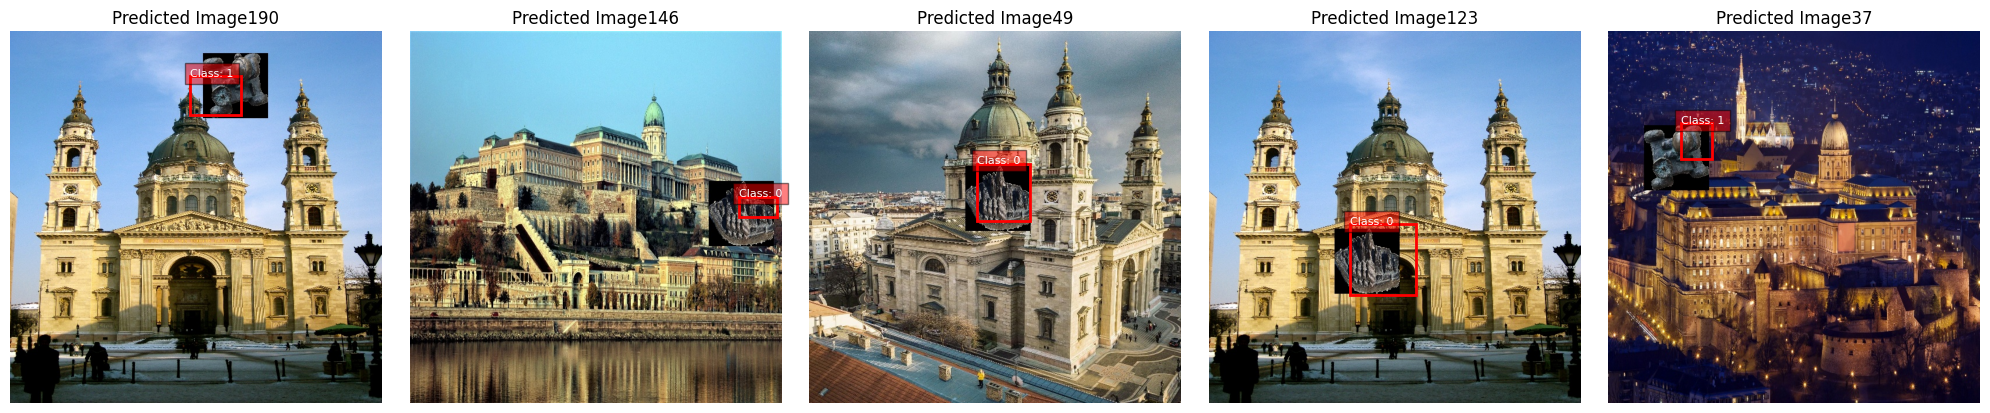

In [17]:
# ADD YOUR CODE HERE
def visualize_predictions(model, test_dataset, num_samples=5):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, category, bbox in test_loader:
            images, category, bbox = images.to(device), category.to(device), bbox.to(device)
            for i in range(len(category)):
                # 存储每个样本的目标
                sample_target = {'category': category[i], 'bbox': bbox[i]}
                all_targets.append(sample_target)

            # 获取模型预测
            outputs_class, outputs_bbox = model(images)
            for i in range(len(outputs_class)):
                # 存储每个样本的预测结果
                sample_output = {'outputs_class': outputs_class[i], 'outputs_bbox': outputs_bbox[i]}
                all_predictions.append(sample_output)

    # 计算子图的行和列数
    num_cols = num_samples
    num_rows = 1

    # 随机选择 num_samples 个样本进行可视化
    sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

    for i, idx in enumerate(sample_indices):
        # 获取图像和标签
        image, label_class, label_bbox = test_dataset[idx]

        # 将图像转移到模型所在的设备上
        image = image.to(device)

        # 获取预测结果
        output = all_predictions[idx]

        # 解析模型输出
        bbox_data = output['outputs_bbox']
        label = output['outputs_class'].argmax().item()

        # 绘制边界框
        x_center = float(bbox_data[0])
        y_center = float(bbox_data[1])
        width = float(bbox_data[2])
        height = float(bbox_data[3])
        x1 = int((x_center - width / 2) * image.shape[2])
        y1 = int((y_center - height / 2) * image.shape[1])
        x2 = int((x_center + width / 2) * image.shape[2])
        y2 = int((y_center + height / 2) * image.shape[1])

        # 绘制图像及边界框
        axes[i].imshow(image.permute(1, 2, 0).cpu().numpy())
        axes[i].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='r', linewidth=2))
        axes[i].text(x1, y1, f'Class: {label}', bbox=dict(facecolor='r', alpha=0.5), fontsize=8, color='white')
        axes[i].set_title(f"Predicted Image{idx}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 调用函数进行可视化
visualize_predictions(model, test_dataset)



### 2.4. Load an existing object detection model
We recommend using YOLOv8, but you are free to use anything else (PyTorch based).



In [18]:
# Install the ultralytics package from PyPI
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 14.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [20]:
import yaml

data = {
    'train': '/content/datasets/train/images',  # 训练集图片路径
    'val': '/content/datasets/val/images',      # 验证集图片路径
    'test': '/content/datasets/test/images',    # 测试集图片路径

    'nc': 3,  # 类别数，根据实际情况修改
    'names': ['boat', 'car', 'beer']  # 类别名称，根据实际情况修改
}

file_path = '/content/mine.yaml'  # 保存文件路径

with open(file_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)


### 2.5. Fine-tune the existing object detection model
If YOLO is chosen, this can be done relatively easy by providing a data.yaml file (which follows a specific format, check github) and running the train script:

i.e. !yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640

or the functional way:
result = yolo.train(data = data_yaml_path, epochs = 40, batch = 10, patience = 30, weight_decay = 0.0005, project = save_path, name = 'train')

Make sure to show the losses and metrics visualizations. By default, YOLO should verbose those.

"""before run this code, must change the file structure by hand!"""

In [21]:
from ultralytics import YOLO

# Create a new YOLO model from scratch
model = YOLO('yolov8n.yaml')

# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8n.pt')

# Train the model using the 'coco8.yaml' dataset for 3 epochs
result = model.train(data = '/content/datasets/mine.yaml', epochs = 40, batch = 64, patience = 30, weight_decay = 0.0005, name = 'train')

# Evaluate the model's performance on the validation set
results = model.val()

100%|██████████| 6.23M/6.23M [00:00<00:00, 355MB/s]

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/mine.yaml, epochs=40, time=None, patience=30, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 122MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:204: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this opera

AMP: checks passed ✅


train: Scanning /content/datasets/train/labels... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:03<00:00, 1362.24it/s]


train: New cache created: /content/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1146.82it/s]

val: New cache created: /content/datasets/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/40      8.55G     0.2714      1.701     0.8135         10        640: 100%|██████████| 79/79 [00:20<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000      0.999          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/40      8.49G     0.1975     0.6433     0.7985         10        640: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000      0.995          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/40      8.49G     0.2182     0.4159     0.8002         13        640: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/40      8.48G     0.2006     0.2806     0.7982         14        640: 100%|██████████| 79/79 [00:17<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/40      8.48G      0.184     0.2272      0.793         20        640: 100%|██████████| 79/79 [00:17<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/40      8.48G     0.1713     0.1984     0.7943          9        640: 100%|██████████| 79/79 [00:17<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/40      8.48G     0.1582     0.1871      0.797         12        640: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/40      8.48G     0.1471     0.1735     0.7898         11        640: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/40      8.48G     0.1387     0.1592     0.7903         13        640: 100%|██████████| 79/79 [00:17<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/40      8.48G     0.1404     0.1596     0.7917          9        640: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/40      8.48G     0.1304     0.1491     0.7933         18        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/40      8.48G      0.132     0.1479     0.7932         11        640: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/40      8.48G     0.1295     0.1507     0.7921         13        640: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/40      8.48G     0.1217     0.1418     0.7892          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/40      8.48G      0.119     0.1367     0.7891         13        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      16/40      8.48G     0.1188     0.1347     0.7905         11        640: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      17/40      8.48G     0.1123     0.1285     0.7899         12        640: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      18/40      8.48G     0.1081     0.1281       0.79         18        640: 100%|██████████| 79/79 [00:17<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      19/40      8.48G     0.1039       0.12     0.7866          9        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      20/40      8.48G     0.1054     0.1235      0.792         10        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      21/40      8.48G      0.103     0.1174     0.7884         13        640: 100%|██████████| 79/79 [00:17<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      22/40      8.48G    0.09629      0.115     0.7861          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      23/40      8.48G    0.09873      0.115     0.7871         17        640: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      24/40      8.48G    0.09387      0.108     0.7869         11        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      25/40      8.48G    0.09214     0.1058     0.7851         12        640: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      26/40      8.48G    0.09173     0.1066     0.7864         11        640: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      27/40      8.48G    0.08805     0.1012     0.7877         14        640: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      28/40      8.48G    0.08348     0.0958     0.7887         15        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      29/40      8.48G     0.0799    0.09525     0.7857         15        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      30/40      8.48G    0.08088    0.09422     0.7848         11        640: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      31/40      8.48G    0.06573    0.07733     0.7689          8        640: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      32/40      8.48G    0.06332    0.07257     0.7697          7        640: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      33/40      8.48G    0.06208     0.0713     0.7704          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      34/40      8.48G    0.05817    0.06655     0.7701          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      35/40      8.48G    0.05704    0.06543     0.7707          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      36/40      8.48G    0.05316    0.06172     0.7695          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      37/40      8.48G    0.05073    0.05819     0.7738          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      38/40      8.48G    0.04947    0.05599     0.7692          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      39/40      8.48G    0.04637    0.05202     0.7682          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      40/40      8.48G    0.04514    0.04948     0.7688          8        640: 100%|██████████| 79/79 [00:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R    

                   all       1000       1000          1          1      0.995      0.995



40 epochs completed in 0.246 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:204: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this opera

Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


                   all       1000       1000          1          1      0.995      0.995
                  boat       1000        332          1          1      0.995      0.995
                   car       1000        354          1          1      0.995      0.995
                  beer       1000        314          1          1      0.995      0.995
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:204: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this opera

                   all       1000       1000          1          1      0.995      0.995
                  boat       1000        332          1          1      0.995      0.995
                   car       1000        354          1          1      0.995      0.995
                  beer       1000        314          1          1      0.995      0.995
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


### 2.6 Evaluate the existing object detection model
Use the same metrics chosen on step 2.3.

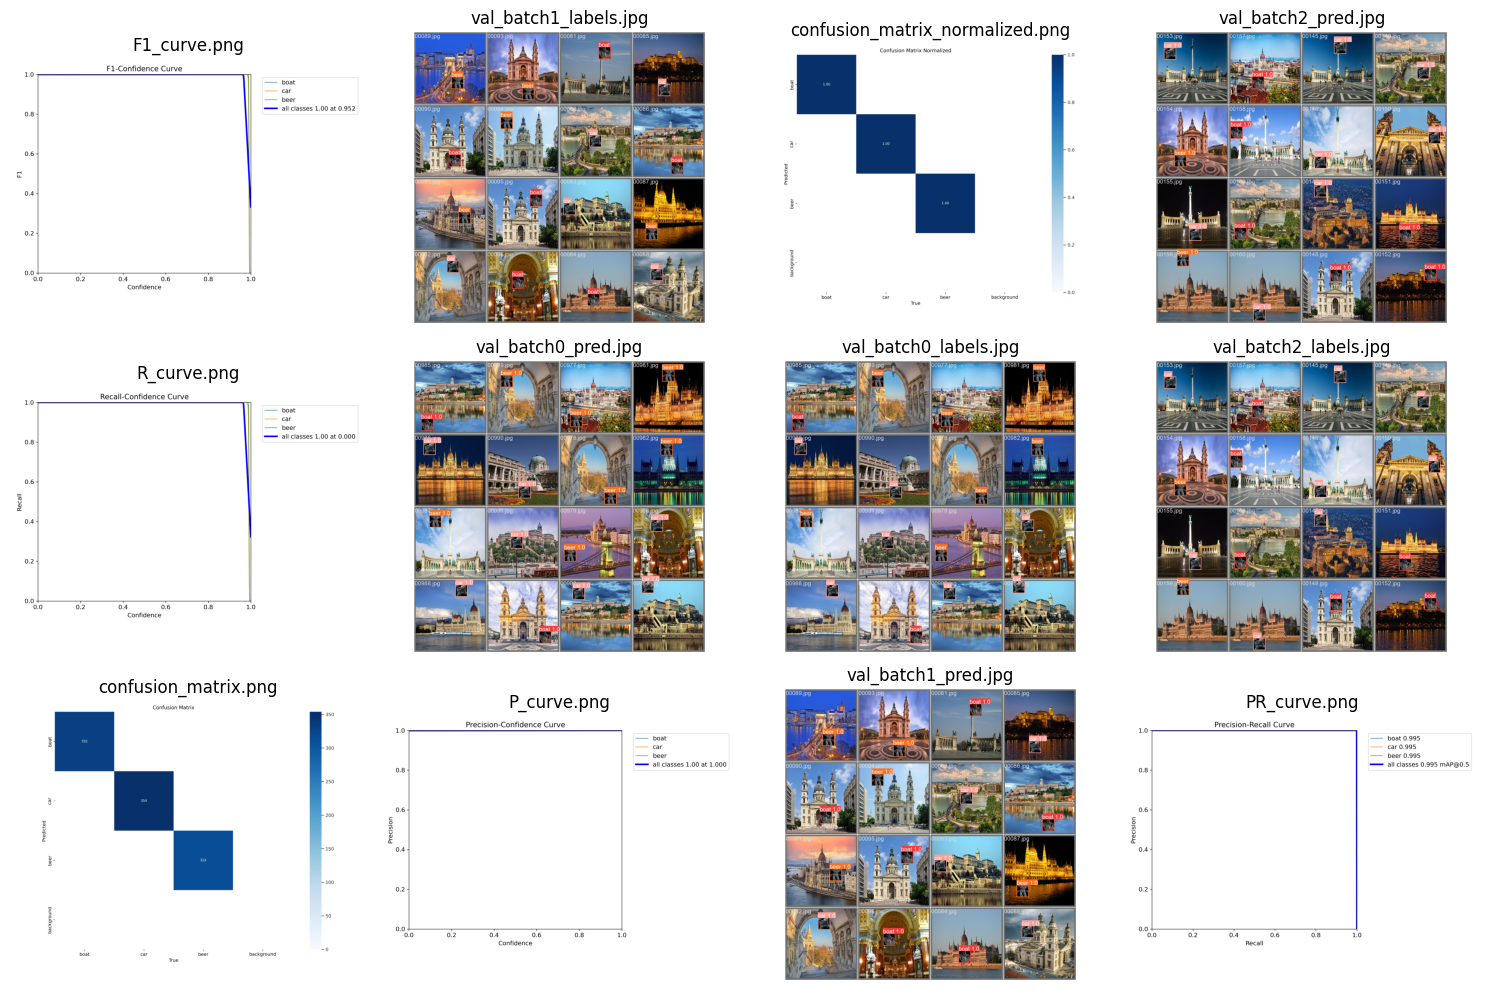

In [25]:
# ADD YOUR CODE HERE
# 设置图片所在的文件夹
folder_path = '/content/runs/detect/train2'

# 获取文件夹内所有文件名
files = os.listdir(folder_path)

# 创建一个图和子图的集合
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# 循环遍历子图和文件名
for ax, file in zip(axes.ravel(), files):
    # 加载图片
    img = Image.open(os.path.join(folder_path, file))
    # 在子图上显示图片
    ax.imshow(img)
    # 设置子图的标题为文件名
    ax.set_title(file)
    # 隐藏坐标轴
    ax.axis('off')

# 调整布局
plt.tight_layout()
# 显示图形
plt.show()

# 3. COMPARISON
Compare the performance of the two models. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

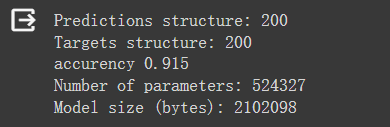

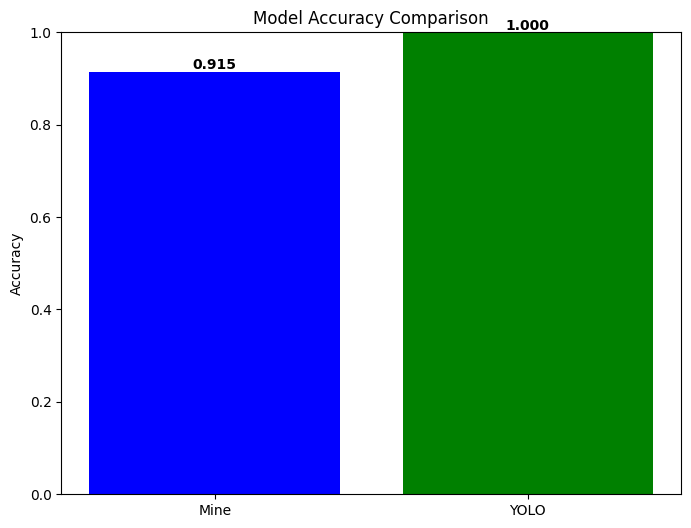

In [27]:
# ADD YOUR CODE HERE
# 设置模型名称和对应的准确率
models = ['Mine', 'YOLO']
accuracies = [0.915, 1.0]

# 创建柱状图
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])

# 添加标题和标签
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # 设置y轴的范围，略高于最高准确率以便更好的视觉效果

# 在柱状图上方添加准确率值
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')

# 显示图表
plt.show()

Obviously, my model is smaller than YOLOv8 in model size and number of parameters. I think the small shortcoming is acceptable. Maybe I can add more layers and more strategies to improve my model.

Thank you for designing this assignment for us! It's interesting and useful. Have a good day!